CT Training and Reconstructions with MoDL
=========================================

This example demonstrates the training and application of a
model-based deep learning (MoDL) architecture described in
<cite data-cite="aggarwal-2019-modl"/> applied to a CT reconstruction problem.

The source images are foam phantoms generated with xdesign.

A class
[scico.flax.MoDLNet](../_autosummary/scico.flax.rst#scico.flax.MoDLNet)
implements the MoDL architecture, which solves the optimization
problem

$$\mathrm{argmin}_{\mathbf{x}} \; \| A \mathbf{x} - \mathbf{y} \|_2^2
+ \lambda \, \| \mathbf{x} - \mathrm{D}_w(\mathbf{x})\|_2^2 \;,$$

where $A$ is a tomographic projector, $\mathbf{y}$ is a set of sinograms,
$\mathrm{D}_w$ is the regularization (a denoiser), and $\mathbf{x}$ is
the set of reconstructed images. The MoDL abstracts the iterative
solution by an unrolled network where each iteration corresponds to a
different stage in the MoDL network and updates the prediction by solving

$$\mathbf{x}^{k+1} = (A^T A + \lambda \, I)^{-1} (A^T \mathbf{y} +
\lambda \, \mathbf{z}^k) \;,$$

via conjugate gradient. In the expression, $k$ is the index of the stage
(iteration), $\mathbf{z}^k = \mathrm{ResNet}(\mathbf{x}^{k})$ is the
regularization (a denoiser implemented as a residual convolutional neural
network), $\mathbf{x}^k$ is the output of the previous stage,
$\lambda > 0$ is a learned regularization parameter, and $I$ is the
identity operator. The output of the final stage is the set of
reconstructed images.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico
'
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install astra-toolbox xdesign

# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install astra-toolbox

# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install astra-toolbox

# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install astra-toolbox

import os
from functools import partial
from time import time

import numpy as np

import jax

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_ct_data
from scico.flax.train.traversals import clip_positive, construct_traversal
from scico.linop.xray.astra import XRayTransform
plot.config_notebook_plotting()

Prepare parallel processing. Set an arbitrary processor count (only
applies if GPU is not available).

In [2]:
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
platform = jax.lib.xla_bridge.get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Read data from cache or generate if not available.

In [3]:
N = 256  # phantom size
train_nimg = 536  # number of training images
test_nimg = 64  # number of testing images
nimg = train_nimg + test_nimg
n_projection = 45  # CT views

trdt, ttdt = load_ct_data(train_nimg, test_nimg, N, n_projection, verbose=True)

Data read from path       :   ~/.cache/scico/examples/data
Set --training--          :   Size:   536
Set --testing --          :   Size:   64
Data range --images  --   :    Min:   0.00, Max: 1.00
Data range --sinogram--   :    Min:   0.00, Max: 0.67
Data range --FBP     --   :    Min:   0.00, Max: 1.00


Build CT projection operator.

In [4]:
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
A = XRayTransform(
    input_shape=(N, N),
    detector_spacing=1,
    det_count=N,
    angles=angles,
)  # CT projection operator
A = (1.0 / N) * A  # normalized

Build training and testing structures. Inputs are the sinograms and
outputs are the original generated foams. Keep training and testing
partitions.

In [5]:
numtr = 100
numtt = 16
train_ds = {"image": trdt["sino"][:numtr], "label": trdt["img"][:numtr]}
test_ds = {"image": ttdt["sino"][:numtt], "label": ttdt["img"][:numtt]}

Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and
relatively short training. The model depth is akin to the number of
unrolled iterations in the MoDL model. The block depth controls the
number of layers at each unrolled iteration. The number of filters is
uniform throughout the iterations. The iterations used for the
conjugate gradient (CG) solver can also be specified. Better
performance may be obtained by increasing depth, block depth, number
of filters, CG iterations, or training epochs, but may require longer
training times.

In [6]:
# model configuration
model_conf = {
    "depth": 10,
    "num_filters": 64,
    "block_depth": 4,
    "cg_iter_1": 3,
    "cg_iter_2": 8,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 12345,
    "opt_type": "SGD",
    "momentum": 0.9,
    "batch_size": 16,
    "num_epochs": 20,
    "base_learning_rate": 1e-2,
    "warmup_epochs": 0,
    "log_every_steps": 40,
    "log": True,
    "checkpointing": True,
}

Construct functionality for making sure that the learned
regularization parameter is always positive.

In [7]:
lmbdatrav = construct_traversal("lmbda")  # select lmbda parameters in model
lmbdapos = partial(
    clip_positive,  # apply this function
    traversal=lmbdatrav,  # to lmbda parameters in model
    minval=5e-4,
)

Print configuration of distributed run.

In [8]:
print(f"{'JAX process: '}{jax.process_index()}{' / '}{jax.process_count()}")
print(f"{'JAX local devices: '}{jax.local_devices()}")

JAX process: 0 / 1
JAX local devices: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3), cuda(id=4), cuda(id=5), cuda(id=6), cuda(id=7)]


Check for iterated trained model. If not found, construct MoDLNet
model, using only one iteration (depth) in model and few CG iterations
for faster intialization. Run first stage (initialization) training
loop followed by a second stage (depth iterations) training loop.

In [9]:
channels = train_ds["image"].shape[-1]
workdir2 = os.path.join(
    os.path.expanduser("~"), ".cache", "scico", "examples", "modl_ct_out", "iterated"
)

stats_object_ini = None
stats_object = None

checkpoint_files = []
for dirpath, dirnames, filenames in os.walk(workdir2):
    checkpoint_files = [fn for fn in filenames]

if len(checkpoint_files) > 0:
    model = sflax.MoDLNet(
        operator=A,
        depth=model_conf["depth"],
        channels=channels,
        num_filters=model_conf["num_filters"],
        block_depth=model_conf["block_depth"],
        cg_iter=model_conf["cg_iter_2"],
    )

    train_conf["post_lst"] = [lmbdapos]
    # Parameters for 2nd stage
    train_conf["workdir"] = workdir2
    train_conf["opt_type"] = "ADAM"
    train_conf["num_epochs"] = 150
    # Construct training object
    trainer = sflax.BasicFlaxTrainer(
        train_conf,
        model,
        train_ds,
        test_ds,
    )
    start_time = time()
    modvar, stats_object = trainer.train()
    time_train = time() - start_time
    time_init = 0.0
    epochs_init = 0
else:
    # One iteration (depth) in model and few CG iterations
    model = sflax.MoDLNet(
        operator=A,
        depth=1,
        channels=channels,
        num_filters=model_conf["num_filters"],
        block_depth=model_conf["block_depth"],
        cg_iter=model_conf["cg_iter_1"],
    )
    # First stage: initialization training loop.
    workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "modl_ct_out")

    train_conf["workdir"] = workdir
    train_conf["post_lst"] = [lmbdapos]
    # Construct training object
    trainer = sflax.BasicFlaxTrainer(
        train_conf,
        model,
        train_ds,
        test_ds,
    )

    start_time = time()
    modvar, stats_object_ini = trainer.train()
    time_init = time() - start_time
    epochs_init = train_conf["num_epochs"]

    print(
        f"{'MoDLNet init':18s}{'epochs:':2s}{train_conf['num_epochs']:>5d}{'':3s}"
        f"{'time[s]:':21s}{time_init:>7.2f}"
    )

    # Second stage: depth iterations training loop.
    model.depth = model_conf["depth"]
    model.cg_iter = model_conf["cg_iter_2"]
    train_conf["opt_type"] = "ADAM"
    train_conf["num_epochs"] = 150
    train_conf["workdir"] = workdir2
    # Construct training object, include current model parameters
    trainer = sflax.BasicFlaxTrainer(
        train_conf,
        model,
        train_ds,
        test_ds,
        variables0=modvar,
    )
    start_time = time()
    modvar, stats_object = trainer.train()
    time_train = time() - start_time

Channels: 1, training signals: 100, testing signals: 16, signal size: 256
+------------------------------------------+----------------+--------+----------+--------+
| Name                                     | Shape          | Size   | Mean     | Std    |
+------------------------------------------+----------------+--------+----------+--------+
| ResNet_0/BatchNorm_0/bias                | (1,)           | 1      | 0.0      | 0.0    |
| ResNet_0/BatchNorm_0/scale               | (1,)           | 1      | 1.0      | 0.0    |
| ResNet_0/ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | 0.0      | 0.0    |
| ResNet_0/ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0      | 0.0    |
| ResNet_0/ConvBNBlock_0/Conv_0/kernel     | (3, 3, 1, 64)  | 576    | 0.0023   | 0.058  |
| ResNet_0/ConvBNBlock_1/BatchNorm_0/bias  | (64,)          | 64     | 0.0      | 0.0    |
| ResNet_0/ConvBNBlock_1/BatchNorm_0/scale | (64,)          | 64     | 1.0      | 0.0    |
| ResNet_0/ConvB

Evaluate on testing data.

In [10]:
del train_ds["image"]
del train_ds["label"]

fmap = sflax.FlaxMap(model, modvar)
del model, modvar

maxn = numtt
start_time = time()
output = fmap(test_ds["image"][:maxn])
time_eval = time() - start_time
output = np.clip(output, a_min=0, a_max=1.0)

Evaluate trained model in terms of reconstruction time
and data fidelity.

In [11]:
total_epochs = epochs_init + train_conf["num_epochs"]
total_time_train = time_init + time_train
snr_eval = metric.snr(test_ds["label"][:maxn], output)
psnr_eval = metric.psnr(test_ds["label"][:maxn], output)
print(
    f"{'MoDLNet training':18s}{'epochs:':2s}{total_epochs:>5d}{'':21s}"
    f"{'time[s]:':10s}{total_time_train:>7.2f}"
)
print(
    f"{'MoDLNet testing':18s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}"
    f"{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

MoDLNet training  epochs:  170                     time[s]:  6644.34
MoDLNet testing   SNR: 11.52 dB   PSNR: 21.90 dB   time[s]:    12.45


Plot comparison.

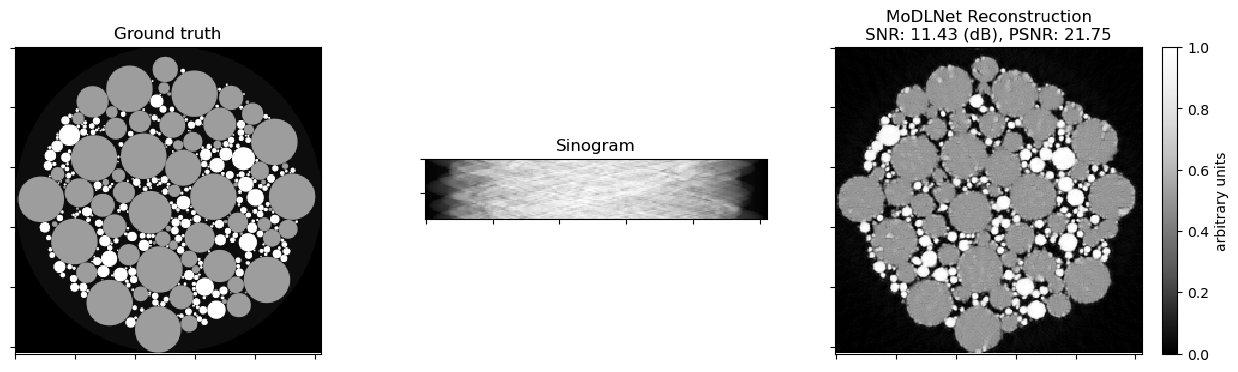

In [12]:
np.random.seed(123)
indx = np.random.randint(0, high=maxn)

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="Sinogram",
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="MoDLNet Reconstruction\nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics are generated only if a training
cycle was done (i.e. if not reading final epoch results from checkpoint).

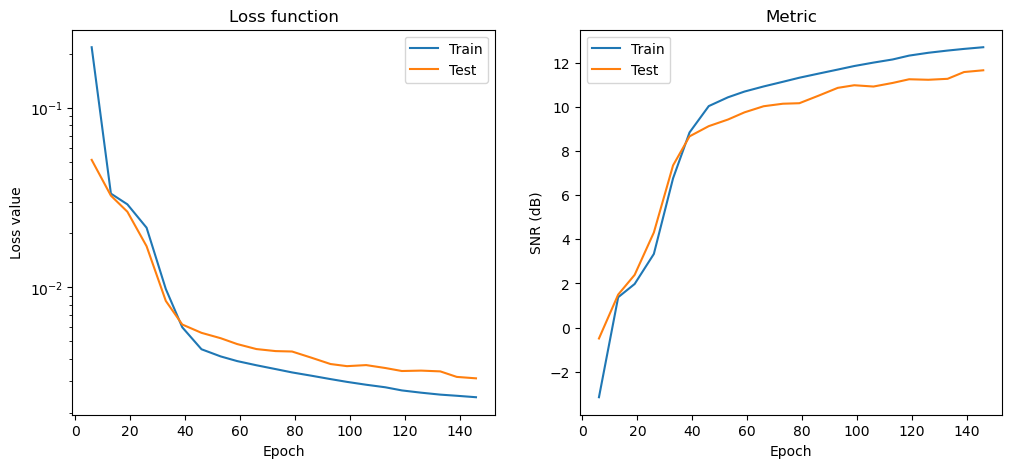

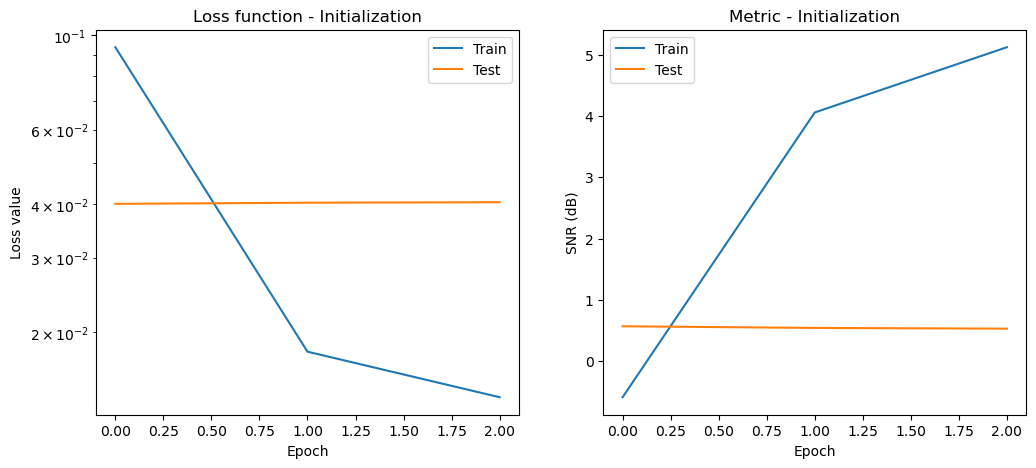

In [13]:
if stats_object is not None and len(stats_object.iterations) > 0:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()

# Stats for initialization loop
if stats_object_ini is not None and len(stats_object_ini.iterations) > 0:
    hist = stats_object_ini.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        ptyp="semilogy",
        title="Loss function - Initialization",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        title="Metric - Initialization",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()